In [2]:
import networkx as nx
import random
import numpy as np
import pandas as pd
from network_build import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load data
driver = pd.read_csv("..//..//..//Database//NYC_trip//driver_260.csv", index_col=0)
order = pd.read_csv("..//..//..//Database//NYC_trip//order_clean_260.csv", index_col=0)
area = np.load("..//..//..//Database//NYC_area//NY_area.npy")

In [8]:
# subnetwork setting
interval = 30
time_list = ['8-830am', '830-9am', '9-930am', '930-10am', '8-10am']

# xtick label format setting

hours = list(range(24 + 1))
hourlabels = [f"{h:02d}:{00:02d}" for h in hours]  # ["00:00", "01:00", ... "23:00", "24:00"]

# create driver's pick up time
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime("2022-06-01 08:00:00 AM")
driver["time"] = pd.date_range(start=start_time, end=start_time, periods=len(driver))
driver.columns = ["id", "time"]
driver_pick = driver.values

In [ ]:
minutes = list(range(240))
minutelabels = [f"{8 + m//60:02d}:{(m) %60:02d}" for m in range(240)]

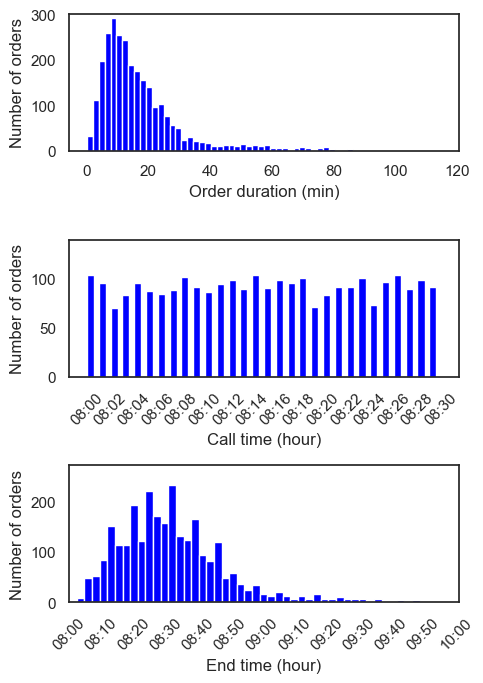

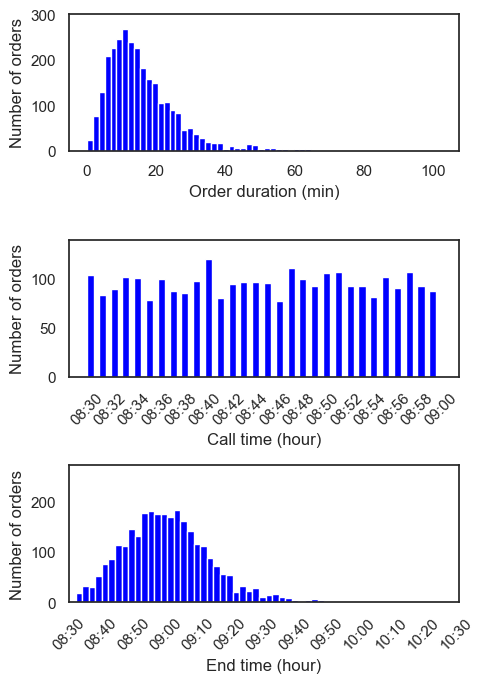

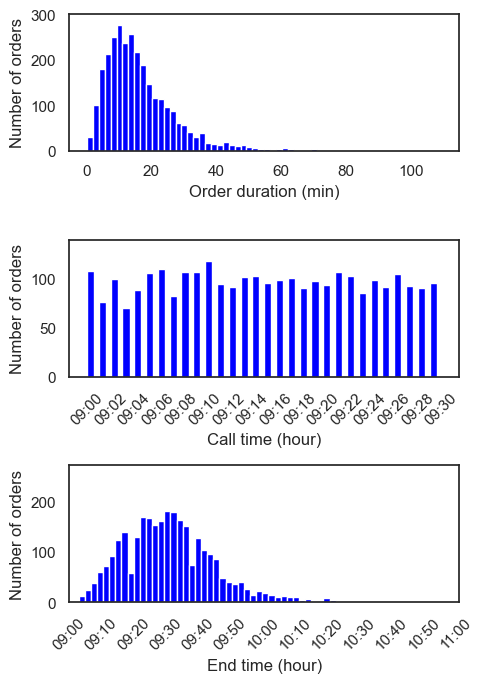

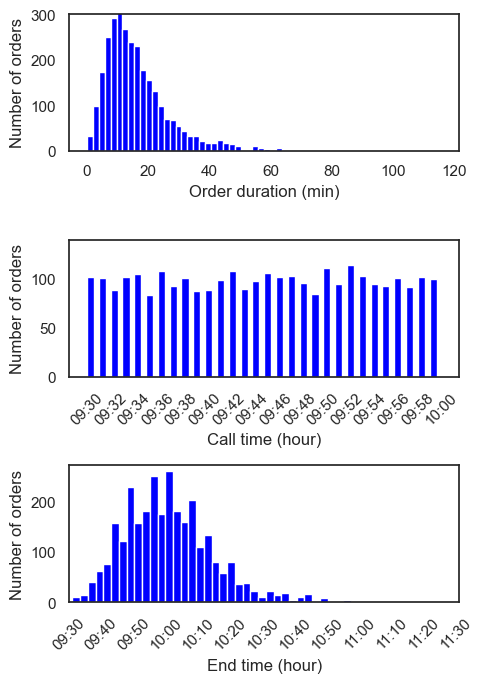

In [ ]:
for i in range(4):
    start_time = pd.to_datetime("2022-06-01 08:00:00 AM") + pd.Timedelta(minutes=i * interval)
    end_time = pd.to_datetime("2022-06-01 08:00:00 AM") + pd.Timedelta(minutes=(i + 1) * interval)
    order_pick = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]
    order_pick = order_pick[["sid", "call_time", "eid", "end_time"]]

    order_pick["delta"] = (
        pd.to_datetime(order_pick["end_time"]) - pd.to_datetime(order_pick["call_time"])
    ).dt.total_seconds()
    order_pick["delta_min"] = order_pick["delta"].apply(lambda x: x / 60)

    sns.set(style="white")
    fig, ax = plt.subplots(3, 1, figsize=(5, 7), tight_layout=True)

    ax[0].hist(order_pick["delta_min"], bins=60, color="blue")
    ax[0].set_xlabel("Order duration (min)")
    ax[0].set_ylabel("Number of orders")
    ax[0].set_ylim(0, 301)

    step = 2
    ax[1].hist(
        [(t.hour - 8) * 60 + t.minute for t in pd.to_datetime(order_pick["call_time"])],
        bins=30,
        color="blue",
        width=0.6,
    )
    ax[1].set_xticks(
        minutes[i * 30 : i * 30 + 31][::step], labels=minutelabels[i * 30 : i * 30 + 31][::step], rotation=45
    )
    ax[1].set_xlabel("Call time (hour)")
    ax[1].set_ylabel("Number of orders")
    ax[2].set_xlim(minutes[i * 30], minutes[i * 30 + 31])
    ax[1].set_ylim(0, 140)

    step = 10
    ax[2].hist([(t.hour - 8) * 60 + t.minute for t in pd.to_datetime(order_pick["end_time"])], bins=60, color="blue")
    ax[2].set_xticks(
        minutes[i * 30 : i * 30 + 121][::step], labels=minutelabels[i * 30 : i * 30 + 121][::step], rotation=45
    )
    ax[2].set_xlabel("End time (hour)")
    ax[2].set_ylabel("Number of orders")
    ax[2].set_xlim(minutes[i * 30], minutes[i * 30 + 121])
    ax[2].set_ylim(0, 271)

    plt.savefig("..//..//..//Database//fig//order_duration_new_%s.png" % time_list[i], dpi=300)

# Construct network and save

In [ ]:
# Only consider order nodes
df_list = []

# create hourly network
for i in range(4):
    start_time = pd.to_datetime("2022-06-01 08:00:00 AM") + pd.Timedelta(minutes=i*interval)
    end_time = pd.to_datetime("2022-06-01 08:00:00 AM") + pd.Timedelta(minutes=(i+1)*interval)
    order_pick = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]
    order_pick = order_pick[["sid", "call_time", "eid", "end_time"]]
    order_pick = order_pick.values

    net = ConstructNetwork(order_pick, driver_pick, area, void = 10)
    G_order = net.build_network(network_type="order")
    net.saveNetwork(G_order, "..//..//..//Database//network8_10//order_%s.gpickle"%time_list[i])
    df = net.network_metrics(G_order)
    df["time"] = time_list[i]
    df_list.append(df)

In [9]:
# create 4-hour network
start_time = pd.to_datetime("2022-06-01 08:00:00 AM") 
end_time = pd.to_datetime("2022-06-01 10:00:00 AM")
order_pick = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]
order_pick = order_pick[["sid", "call_time", "eid", "end_time"]]
order_pick = order_pick.values

net = ConstructNetwork(order_pick, driver_pick, area, void = 10)
G_order = net.build_network(network_type="order")
net.saveNetwork(G_order, "..//..//..//Database//network8_10//order_%s.gpickle"%time_list[-1])
df_4h = net.network_metrics(G_order)
df_4h["time"] = time_list[-1]
df_list.append(df_4h)

KeyboardInterrupt: 

In [ ]:
df_all = pd.concat(df_list, axis=0)
df_all.to_csv("..//..//..//Database//network8_10//network_metrics.csv")

# Read files, read network

In [ ]:
df_all = pd.read_csv("..//..//..//Database//network8_10//network_metrics.csv", index_col=0)
G_order_8_830 = nx.read_gpickle("..//..//..//Database//network8_10//order_8-830am.gpickle")
G_order_830_9 = nx.read_gpickle("..//..//..//Database//network8_10//order_830-9am.gpickle")
G_order_9_930 = nx.read_gpickle("..//..//..//Database//network8_10//order_9-930am.gpickle")
G_order_930_10 = nx.read_gpickle("..//..//..//Database//network8_10//order_930-10am.gpickle")
G_order_8_10 = nx.read_gpickle("..//..//..//Database//network8_10//order_8-10am.gpickle")

In [ ]:
G_list = [G_order_8_10]

for G in G_list:
    G.add_node('sink')
    for node in G.nodes():
        if node != 'sink':
            G.add_edge(node, 'sink', weight=0)

In [ ]:
def single_source_longest_dag_path_length(graph, s):
    assert(graph.in_degree(s) == 0)
    dist = dict.fromkeys(graph.nodes, -float('inf'))
    dist[s] = 0
    topo_order = nx.topological_sort(graph)
    for n in topo_order:
        for s in graph.successors(n):
            if dist[s] < dist[n] + graph.edges[n,s]['weight']:
                dist[s] = dist[n] + graph.edges[n,s]['weight']
    return dist

def single_sink_longest_dag_path(graph, s):
    assert(graph.out_degree(s) == 0)
    dist = dict.fromkeys(graph.nodes, -float('inf'))
    dist[s] = 0
    topo_order = list(reversed(list(nx.topological_sort(graph))))
    for n in topo_order:
        for s in graph.predecessors(n):
            if dist[s] < dist[n] + 1:
                dist[s] = dist[n] + 1
    return dist

MTC = single_sink_longest_dag_path(G_order_8_10, 'sink')
del MTC['sink']

In [ ]:
# Naive method to find the longest path in a DAG (very expensive)
# MTC = {}
# for G in G_list:
#     for node in ['t0', 't7', 't8', 't9', 't39', 't40', 't41', 't42']:
#         MTC[node] = len(max(nx.all_simple_paths(G, node, 'sink'), key=lambda x: len(x))) - 1
# MTC

In [ ]:
df_all['MTC'] = list(MTC.values()) + list(MTC.values())
df_all['full_network'] = df_all['time'] == '8-10am'
df_all.to_csv("..//..//..//Database//network8_10//network_metrics_MTC.csv")

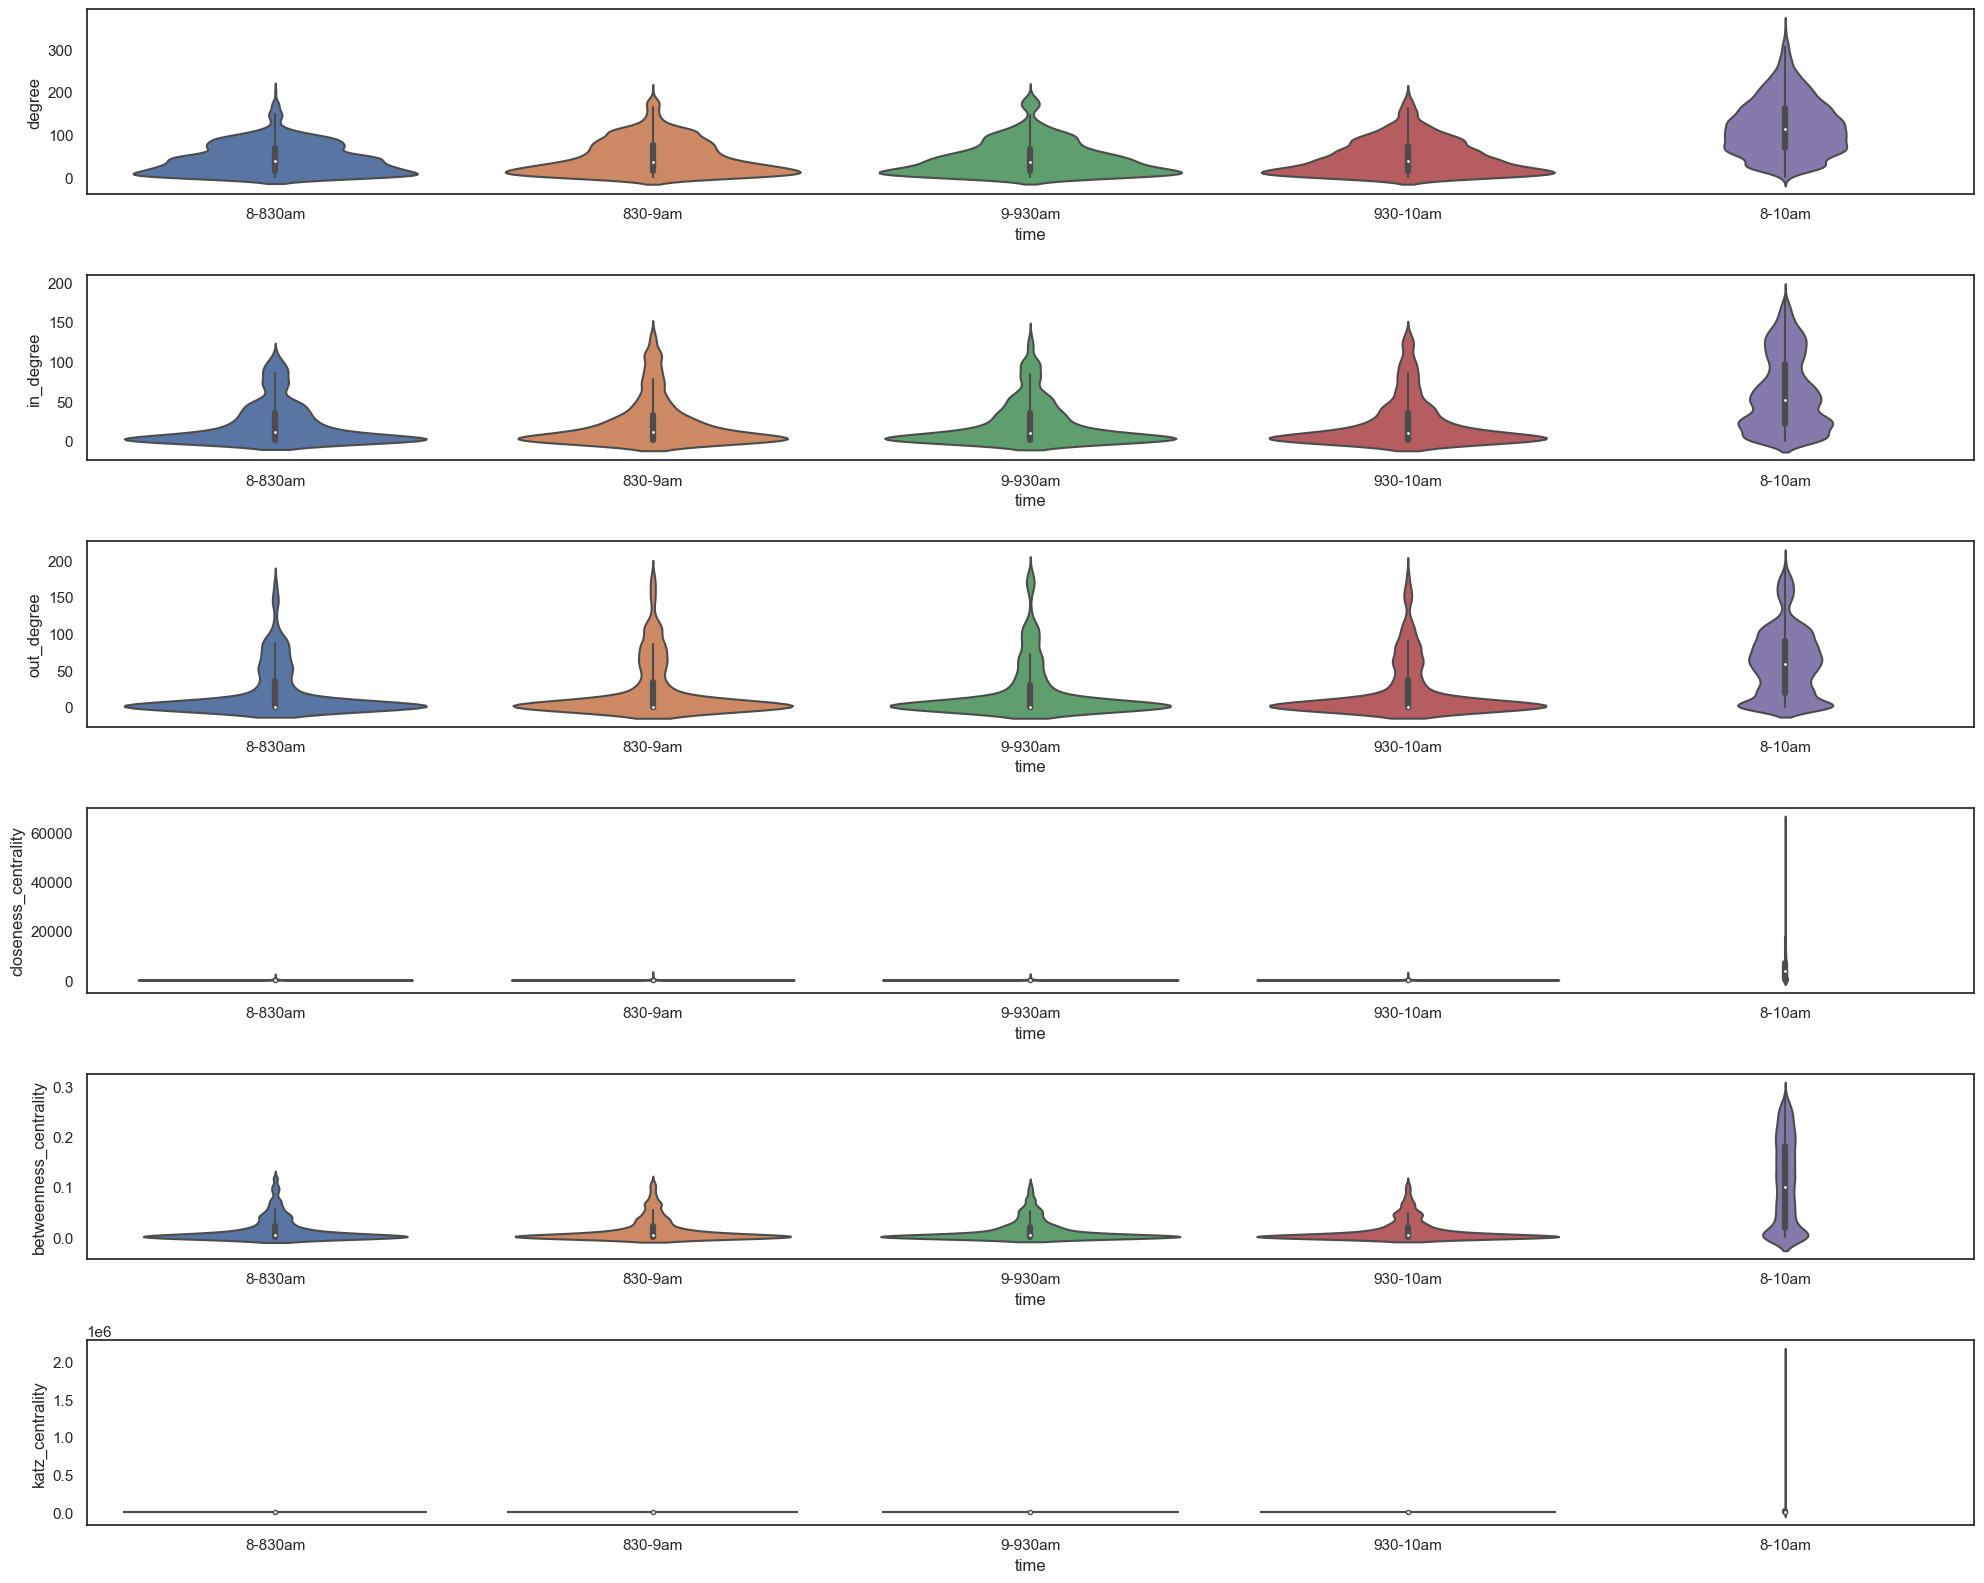

In [ ]:
figure, axes = plt.subplots(6, 1, figsize=(20, 16), tight_layout=True)
axes = axes.flatten()
sns.violinplot(x="time", y="degree", data=df_all, ax=axes[0], fill=False)
sns.violinplot(x="time", y="in_degree", data=df_all, ax=axes[1], fill=False)
sns.violinplot(x="time", y="out_degree", data=df_all, ax=axes[2], fill=False)

sns.violinplot(x="time", y="closeness_centrality", data=df_all, ax=axes[3])
sns.violinplot(x="time", y="betweenness_centrality", data=df_all, ax=axes[4])
sns.violinplot(x="time", y="katz_centrality", data=df_all, ax=axes[5])
plt.show()

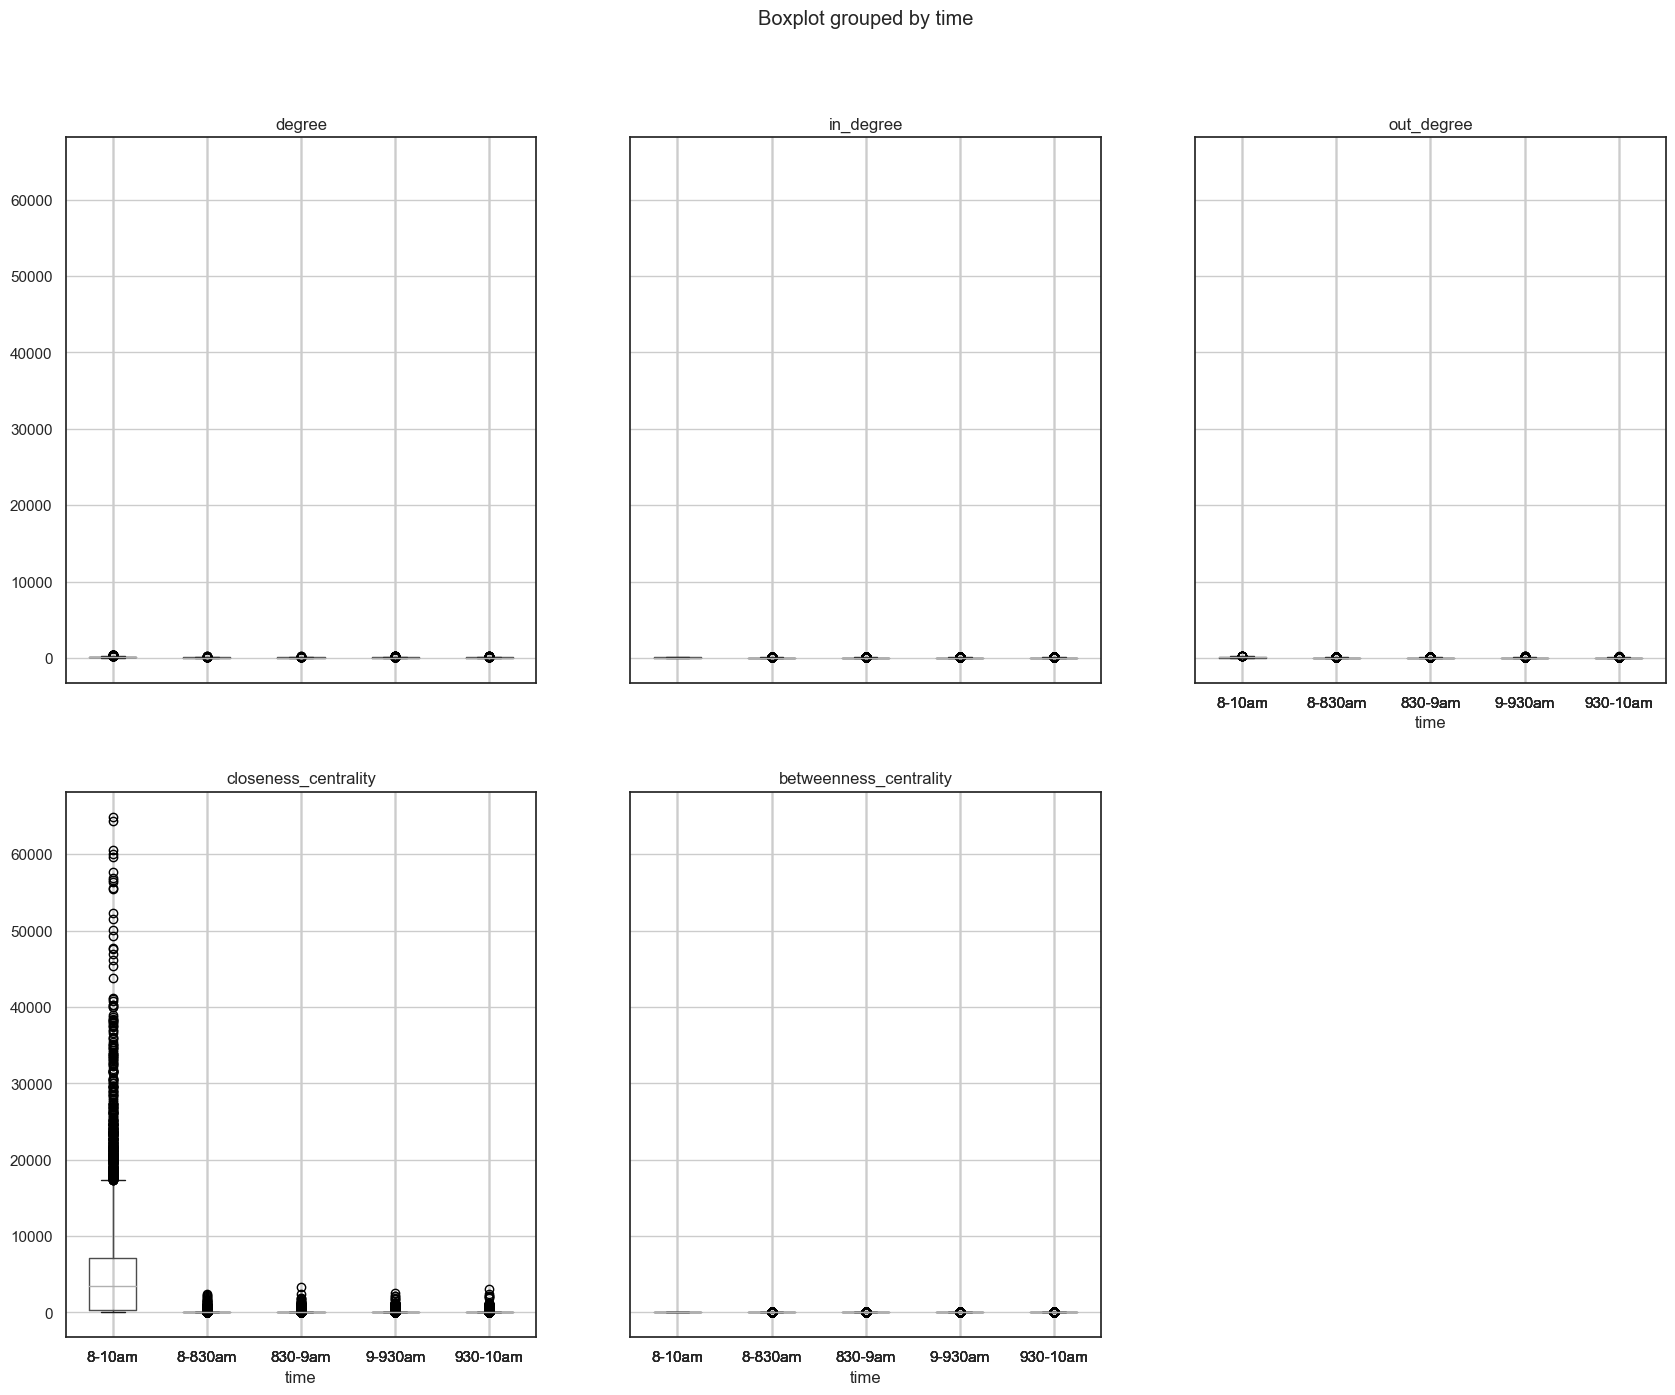

In [ ]:
df_all.boxplot(column=["degree", "in_degree", "out_degree", "closeness_centrality", "betweenness_centrality"], by="time", figsize=(20, 16), layout=(2, 3))
plt.show()

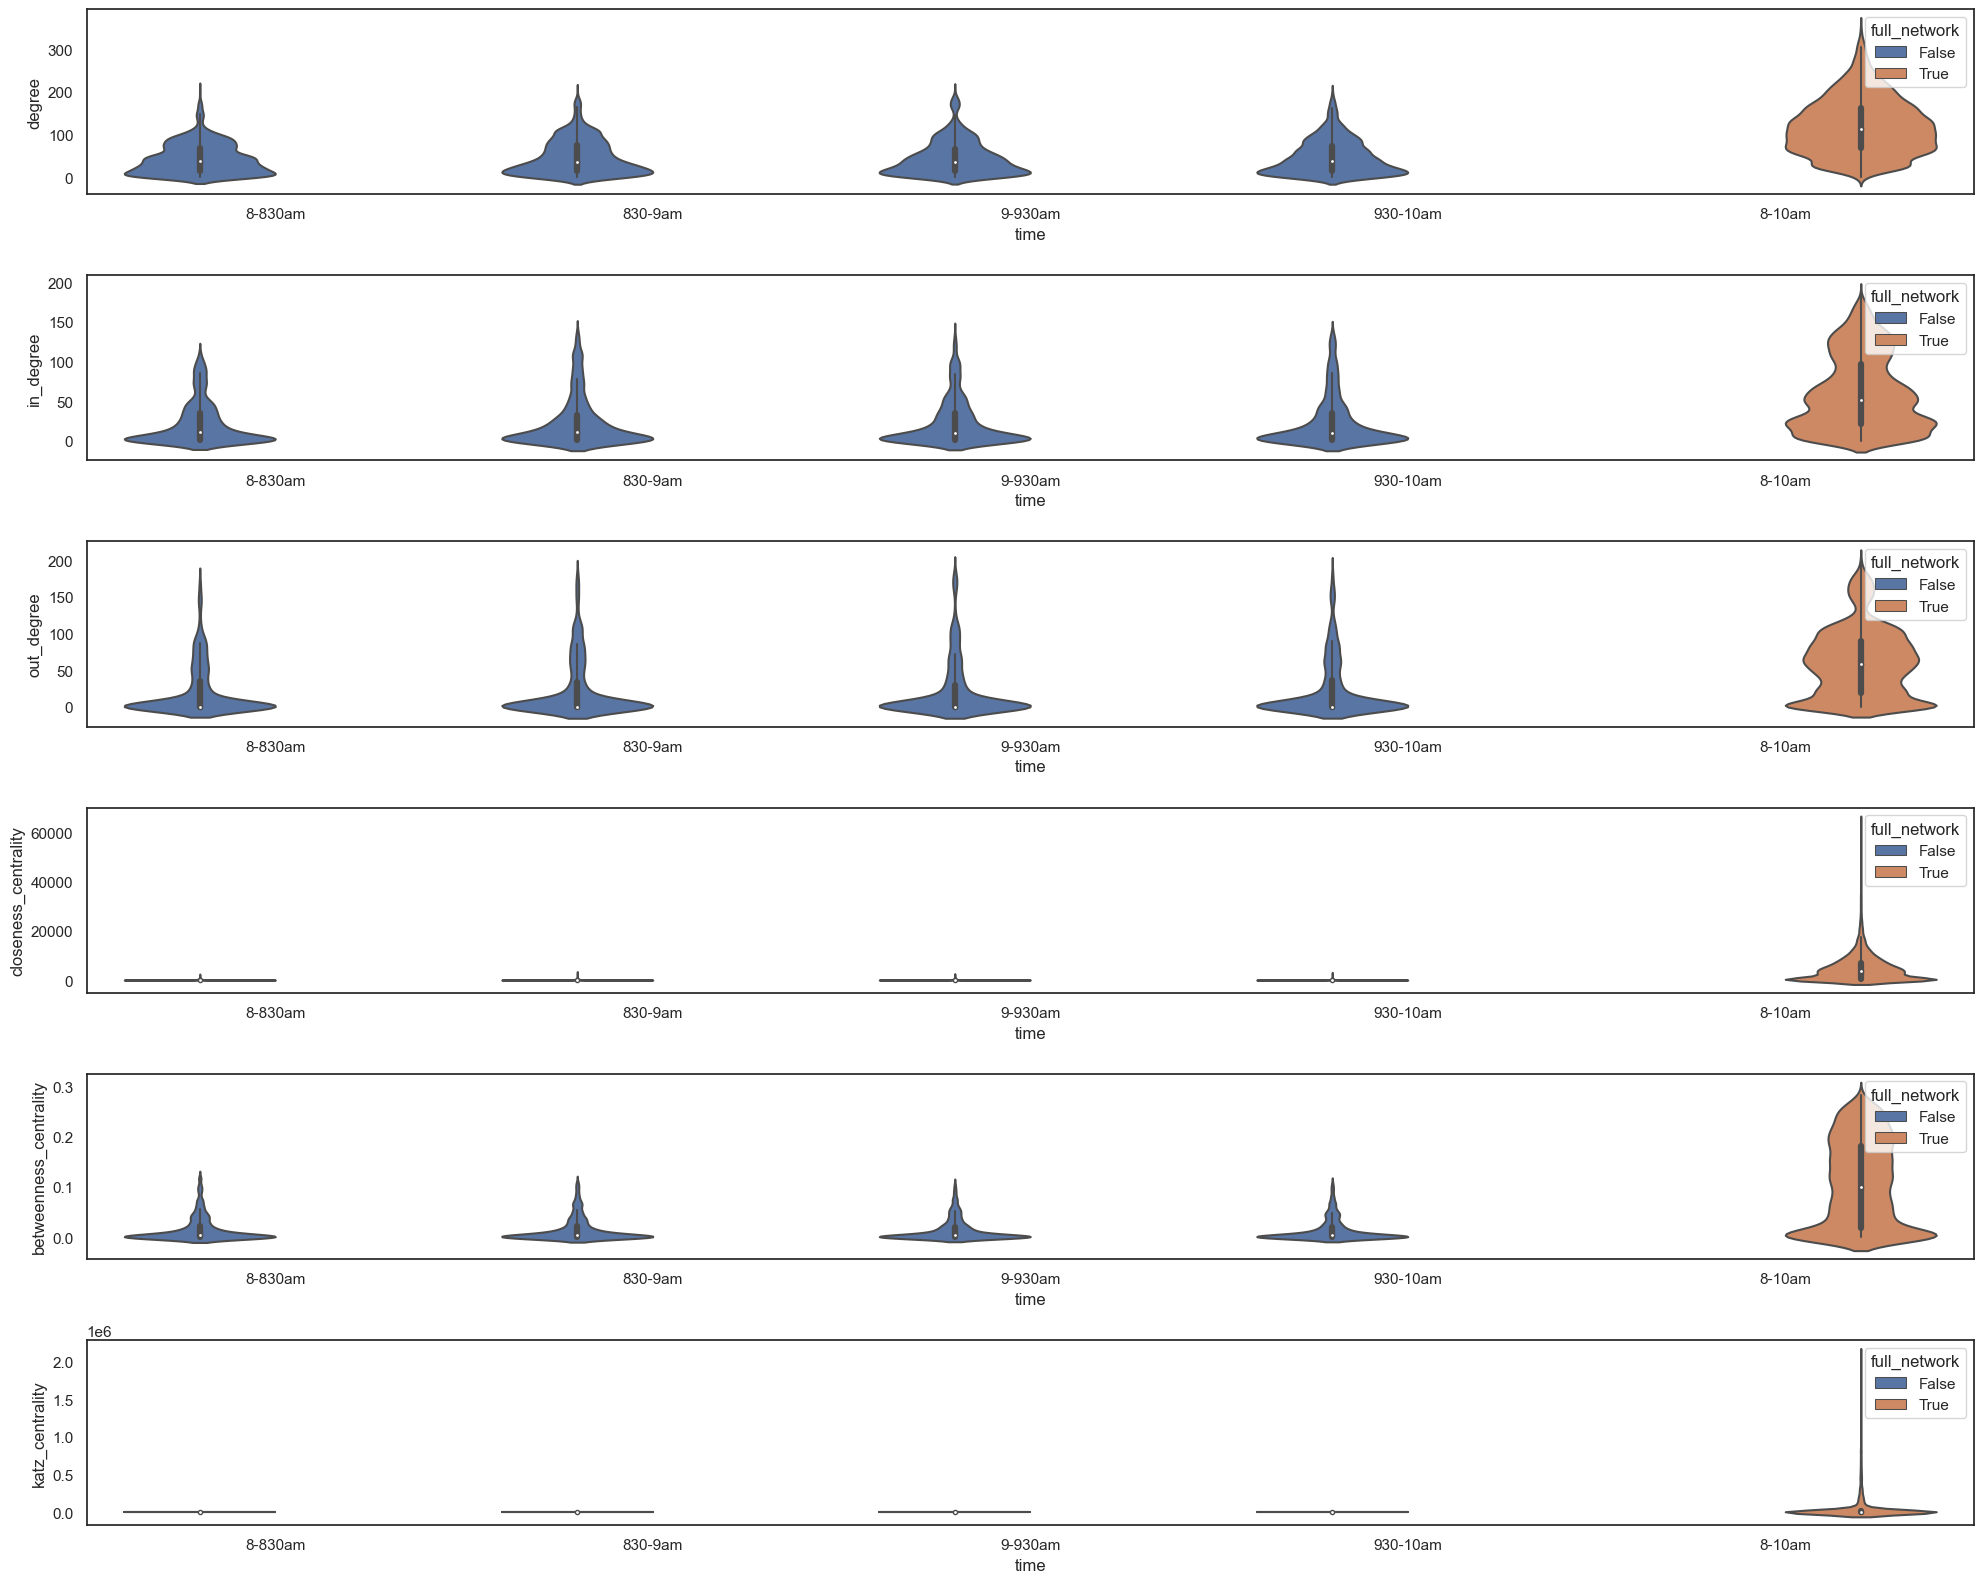

In [ ]:
figure, axes = plt.subplots(6, 1, figsize=(20, 16), tight_layout=True)
axes = axes.flatten()
sns.violinplot(x="time", y="degree", data=df_all, hue='full_network', ax=axes[0])
sns.violinplot(x="time", y="in_degree", data=df_all, hue='full_network', ax=axes[1])
sns.violinplot(x="time", y="out_degree", data=df_all, hue='full_network', ax=axes[2])

sns.violinplot(x="time", y="closeness_centrality", data=df_all, hue='full_network',  ax=axes[3])
sns.violinplot(x="time", y="betweenness_centrality", data=df_all, hue='full_network', ax=axes[4])
sns.violinplot(x="time", y="katz_centrality", data=df_all, hue='full_network', ax=axes[5])
plt.show()

In [ ]:
# figure, axes = plt.subplots(4, 1, figsize=(20, 10))
# axes = axes.flatten()
# sns.boxplot(x="time", y="degree_centrality", data=df_all_new, hue='full_network', ax=axes[0])
# sns.boxplot(x="time", y="closeness_centrality", data=df_all_new, hue='full_network',  ax=axes[1])
# sns.boxplot(x="time", y="betweenness_centrality", data=df_all_new, hue='full_network', ax=axes[2])
# sns.boxplot(x="time", y="katz_centrality", data=df_all_new, hue='full_network', ax=axes[3])
# plt.show()